# IALP Forecating Analysis

In [36]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from src.utils import mean_absolute_scaled_error
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})
from src.plotting import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm





In [37]:
ialp = pd.read_csv("data/processed/IALP_Monthly_Revenue.csv")
ialp = ialp[['Year_Month','Revenue']]
ialp['Year_Month'] = pd.to_datetime(ialp['Year_Month'], format='%Y-%m')
ialp = ialp.set_index('Year_Month')
ialp.head()

,Revenue
Year_Month,
2019-01-01,13592.90
2019-02-01,12056.32
2019-03-01,22004.13
2019-04-01,11650.20
2019-05-01,10213.00


# EDA 

<Axes: xlabel='Time', ylabel='Revenue'>

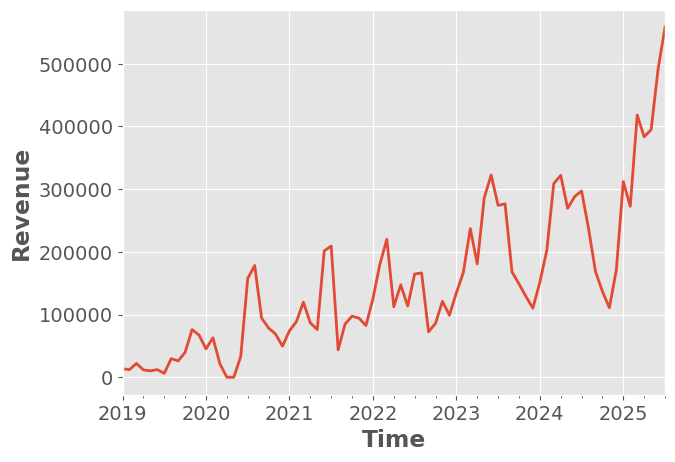

In [38]:
# Visualize the whole dataset
ialp.plot.line(xlabel="Time", ylabel="Revenue", legend=False)

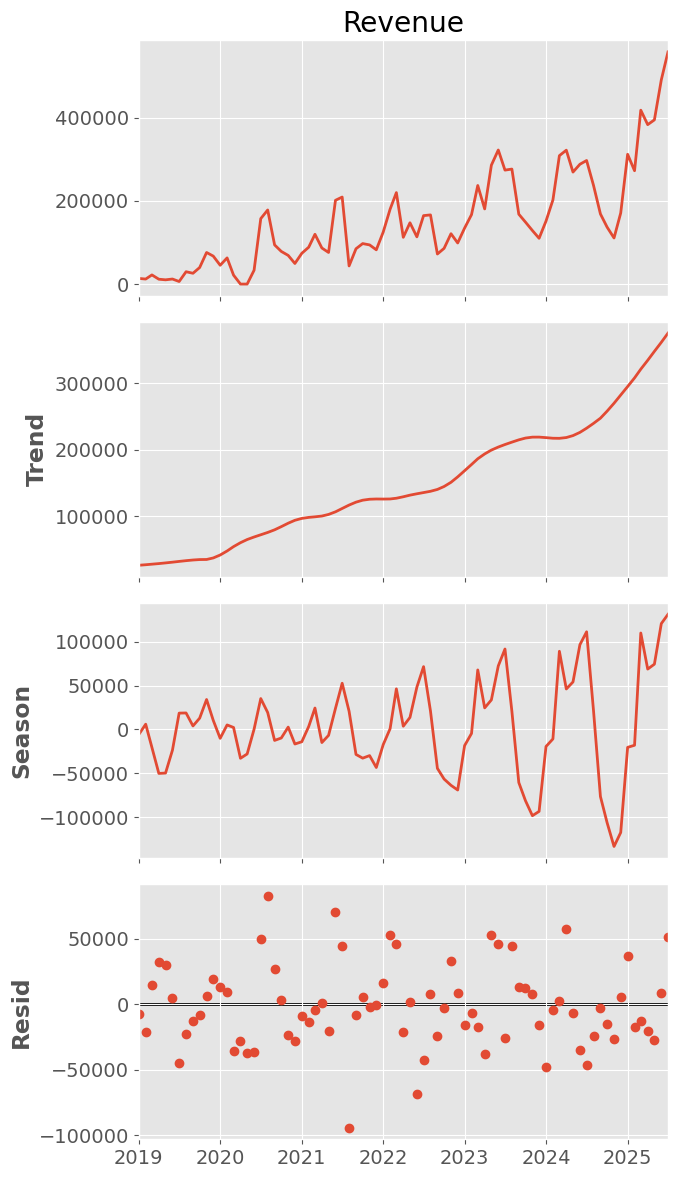

In [39]:
# Decompose the data with STL 
model = STL(ialp["Revenue"], period=12, seasonal=13).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(7, 12))
    model.plot()

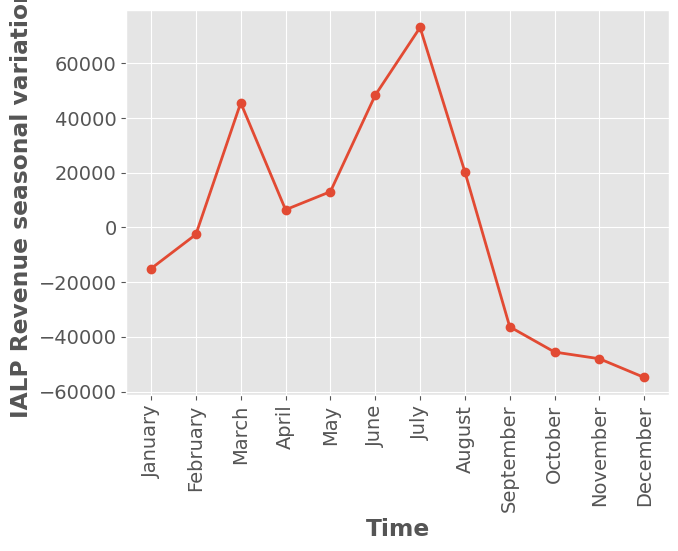

In [40]:
seasonal = model.seasonal.groupby(model.seasonal.index.month).mean()
seasonal.plot.line(xlabel="Time", ylabel="IALP Revenue seasonal variation", marker="o")
plt.xticks(range(1, 13), calendar.month_name[1:], rotation='vertical');

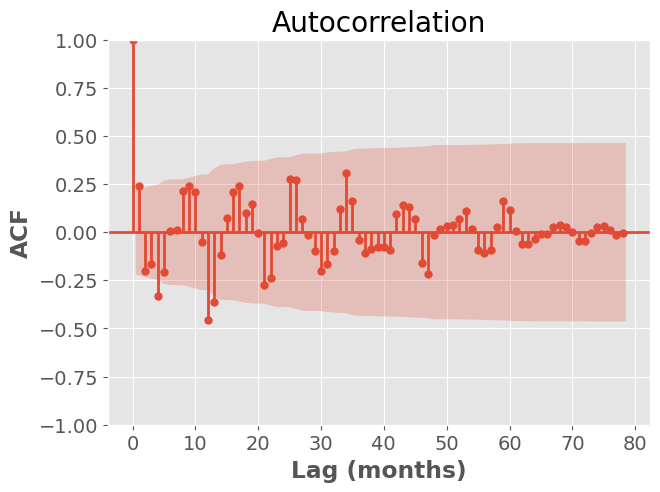

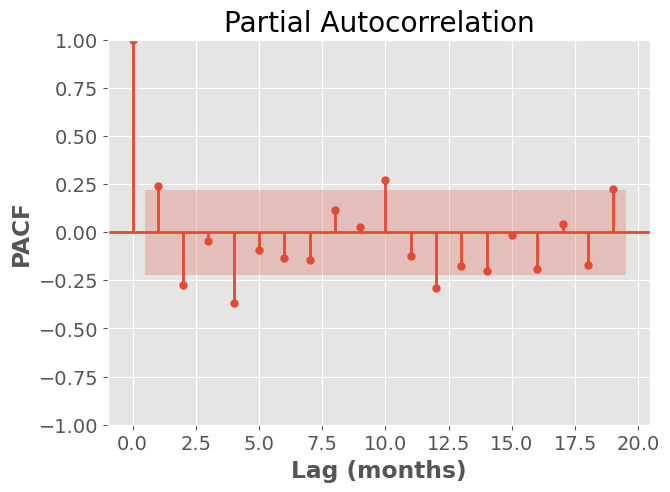

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_fig = plot_acf(model.resid, lags=78)
plt.ylabel("ACF")
plt.xlabel("Lag (months)");
pacf_fig = plot_pacf(model.resid)
plt.ylabel("PACF")
plt.xlabel("Lag (months)");

### The whole data set show obvious trend, seasonality, and signals of autocorrelation.

In [42]:
# Accuracy function for evaluation.
def accuracy(y_pred, y_test, y_train, modelname="Results"):
    """Calculate forecast accuracy.

    Parameters
    ----------
    y_pred : pandas.Series
        Predictions of y_test.
    y_test : pandas.Series
        Test observations.
    y_train : pandas.Series
        Train observations. Required for MASE.
    modelname : str, optional
        Name of output dataframe index.
        By default = "Results".

    Returns
    -------
    pandas.DataFrame
        A dataframe of the following metrics: MAE,
        RMSE, MAPE, MASE.
    """
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return pd.DataFrame([[mae, rmse, mape, mase]],
                        columns=["MAE", "RMSE", "MAPE", "MASE"],
                        index=[modelname])

In [43]:
# Read in Train data (Split from raw data)
train = pd.read_csv("/Users/warroom/Desktop/model_v3/data/processed/train.csv")
train['Year_Month'] = pd.to_datetime(train['Year_Month'], format='%Y-%m')
train = train.set_index('Year_Month').assign(Label="Observed")

In [44]:
# Read in Test data (Split from raw data)
test = pd.read_csv("/Users/warroom/Desktop/model_v3/data/processed/test.csv")
test['Year_Month'] = pd.to_datetime(test['Year_Month'], format='%Y-%m')

test = test.set_index('Year_Month').sort_index().assign(Label="Actual")

In [45]:
# For easy index alignment
def create_forecast_index(start, horizon, freq="MS"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")


forecast_index = create_forecast_index(train.index[-1], 12)
forecast_index

DatetimeIndex(['2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01'],
              dtype='datetime64[ns]', name='Time', freq='MS')

# Base line model: Seasonal naive forecast

In [46]:
# Take the last 12 month value as the forecast value
train["month"] = train.index.month
last_season = (train.drop_duplicates("month", keep="last")
                 .sort_values(by="month")
                 .set_index("month")["Revenue"]
              )
train = train.drop(columns="month")
last_season

month
1     151504.52
2     202413.28
3     308880.98
4     322050.17
5     269365.88
6     288188.05
7     297219.35
8     276627.68
9     168059.93
10    148969.66
11    128748.77
12    110110.22
Name: Revenue, dtype: float64

In [47]:
# Seasonal naive
# Set each forecast as the last observed value from the same season of the year (e.g., the same month of the previous year)
seasonal = pd.DataFrame(index=forecast_index)
seasonal = seasonal.assign(**{"Revenue": seasonal.index.month.map(lambda x: last_season.to_dict()[x]),
                              "Label": "Seasonal naive forecast"}
                          )             
seasonal.head()

,Revenue,Label
Time,,
2024-08-01,276627.68,Seasonal naive forecast
2024-09-01,168059.93,Seasonal naive forecast
2024-10-01,148969.66,Seasonal naive forecast
2024-11-01,128748.77,Seasonal naive forecast
2024-12-01,110110.22,Seasonal naive forecast


In [48]:
# Visualize the result
px.line(pd.concat((train,test, seasonal)), y="Revenue", color="Label", width=950)

In [49]:
results_Season_Naive = accuracy(seasonal['Revenue'], test['Revenue'], train['Revenue'], modelname="Season Naive")
results_Season_Naive

,MAE,RMSE,MAPE,MASE
Season Naive,93517.235833,121585.533457,0.263972,2.586384


# Moving Forward: Exponential Models

In [50]:
# Avoid the effects of havign a 0 in the data set
train['Revenue'] = train['Revenue'] + 1e-6
test['Revenue'] = test['Revenue'] + 1e-6
train.head()

,Unnamed: 0,Revenue,Date,Label
Year_Month,,,,
2019-01-01,0,13592.900001,2019-01-01,Observed
2019-02-01,1,12056.320001,2019-02-01,Observed
2019-03-01,2,22004.130001,2019-03-01,Observed
2019-04-01,3,11650.200001,2019-04-01,Observed
2019-05-01,4,10213.000001,2019-05-01,Observed


In [51]:
# Initiate teh ETS model
ets_model = ETSModel(
    np.log1p(train['Revenue']),   # log(Revenue+1)，允许0值,
    error="mul", trend="mul", 
    seasonal="mul", 
    seasonal_periods=12,
    #damped_trend=True,
    #initialization_method="heuristic"
).fit()

#forecast_index = create_forecast_index(train.index[-1], 19)
forecast_index = pd.date_range(
    start=train.index.max() + pd.DateOffset(months=1),
    periods=12,
    freq='MS'  # Month Start
)

ets_forecast = np.expm1(ets_model.forecast(len(forecast_index)))

ets= pd.DataFrame({"Revenue": ets_forecast,
                        "Label": "ETS (AAA)"},
                       index=forecast_index)


print(f"Model AIC: {ets_model.aic:.2f}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53940D+00    |proj g|=  4.57369D+00

At iterate    1    f=  2.40982D+00    |proj g|=  8.81058D-01

At iterate    2    f=  2.38727D+00    |proj g|=  2.12018D+00

At iterate    3    f=  2.33877D+00    |proj g|=  2.58547D+00

At iterate    4    f=  2.27933D+00    |proj g|=  5.28950D+00

At iterate    5    f=  2.23567D+00    |proj g|=  1.44927D+00

At iterate    6    f=  2.18292D+00    |proj g|=  4.01192D+00
  ys=-4.858E-03  -gs= 5.300E-02 BFGS update SKIPPED

At iterate    7    f=  2.18259D+00    |proj g|=  1.88712D-01

At iterate    8    f=  2.18248D+00    |proj g|=  1.86974D-01

At iterate    9    f=  2.18116D+00    |proj g|=  1.00514D+00

At iterate   10    f=  2.17837D+00    |proj g|=  1.45965D+00

At iterate   11    f=  2.17214D+00    |proj g|=  5.32752D+00

At iterate   12    f=  2.15663D+00  

In [52]:
# Visualize
px.line(pd.concat((train,test, ets)), y="Revenue", color="Label", width=820)

In [53]:
results_ETS = accuracy(ets['Revenue'], test['Revenue'], train['Revenue'], modelname="ETS")
results_ETS

,MAE,RMSE,MAPE,MASE
ETS,82089.154722,99911.487741,0.453485,2.270321


# Holt-Winter‘s Method

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train['Revenue'] = train['Revenue'] + 1e-6
test['Revenue'] = test['Revenue'] + 1e-6

# Use Holt-Winters Method
hw_model = ExponentialSmoothing(
    train['Revenue'], 
    trend='add', 
    seasonal='mul', 
    #damped_trend=True,
    seasonal_periods=12
).fit()

forecast = hw_model.forecast(steps=len(forecast_index))


In [55]:
# Result dataframe
forecast_values = hw_model.forecast(steps=len(forecast_index))
hw = pd.DataFrame(index=forecast_index)
hw['Revenue'] = forecast_values.values if hasattr(forecast_values, 'values') else forecast_values
hw['Label'] = "Holt-Winters"

In [56]:
px.line(pd.concat((train,test, hw)), y="Revenue", color="Label", width=820)

In [57]:
results_Holt_Winter = accuracy(hw['Revenue'], test['Revenue'], train['Revenue'], modelname="Holt Winter's")
results_Holt_Winter

,MAE,RMSE,MAPE,MASE
Holt Winter's,69143.475969,89736.327259,0.21273,1.912285


# Moving Forward: SARIMA (auto mode)

In [58]:
import pmdarima as pm

y = train['Revenue']

# 自动拟合 SARIMA
sarima_model = pm.auto_arima(
    train['Revenue'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=12,
    d=1, D=1,   # Force at least one seasonal differencing
    trace=True,
    stepwise=True)


print(sarima_model.summary())

# Forecast future 12 months
sarima_forecast = sarima_model.predict(n_periods=12)

# 构造预测索引
forecast_index = pd.date_range(
    start=train.index.max() + pd.DateOffset(months=1),
    periods=12, freq="MS"
)

sarima= pd.DataFrame({"Revenue": sarima_forecast, "Label": "SARIMA"},
                              index=forecast_index)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1360.503, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1346.346, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1344.700, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1355.016, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1345.692, Time=0.04 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1345.707, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1345.950, Time=0.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1347.673, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1337.977, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1337.905, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1343.471, Time=0.01 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1339.326, Time=0.25 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1345.041, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1343.042, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0

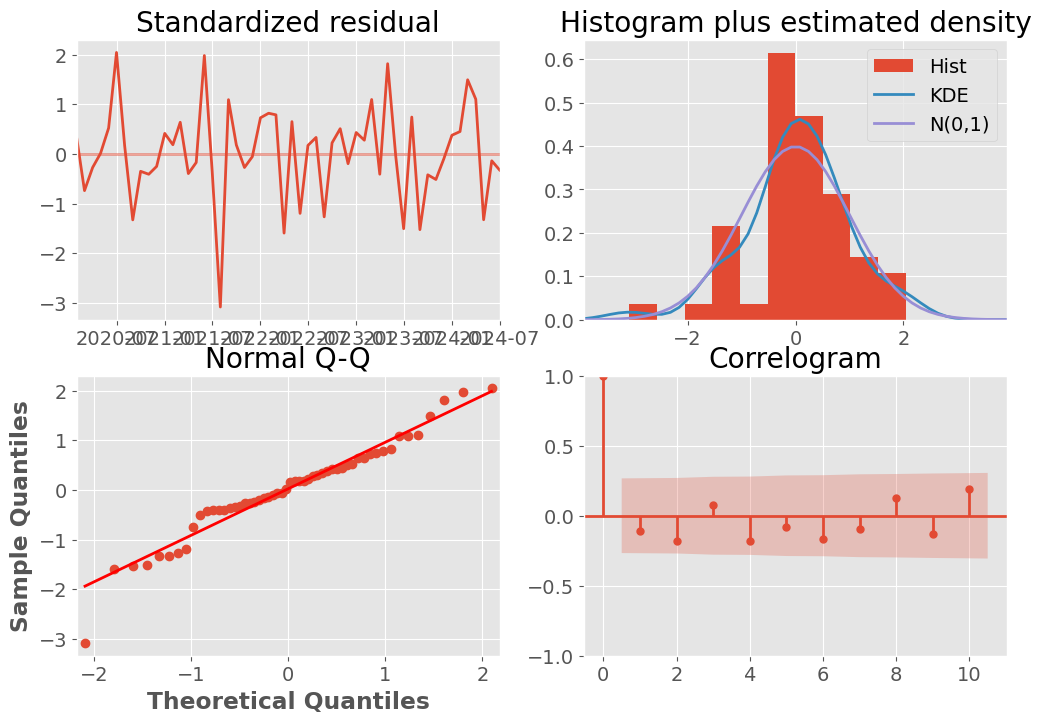

In [59]:
sarima_model.plot_diagnostics(figsize=(12,8));

In [60]:
px.line(pd.concat((train,test, sarima)), y="Revenue", color="Label", width=820)

In [61]:
results_SARIMA = accuracy(sarima['Revenue'], test['Revenue'], train['Revenue'], modelname="SARIMA")
results_SARIMA

,MAE,RMSE,MAPE,MASE
SARIMA,91705.224109,107084.980808,0.353543,2.53627


# STL + ARIMA


In [62]:


# ---------- 配置 ----------
H = 12            # 预测步长（未来12个月）
M = 12            # 季节周期（月度=12）
USE_DAMPED = False # 趋势是否用阻尼（对长期外推通常更稳）

# ---------- 数据准备 ----------
y_train = train['Revenue'].astype(float).copy()
y_test  = test['Revenue'].astype(float).copy()

# 统一频率（用月初 MS；若你用月末 M，请改为 'M'）
freq = y_train.index.freq or y_train.index.inferred_freq or 'MS'
y_train = y_train.asfreq(freq)
y_test  = y_test.asfreq(freq)

# ---------- 变换：log1p（允许0值；若有负值会报错，可改为只做加法模型） ----------
if (y_train < 0).any():
    raise ValueError("存在负值，不适合 log1p，请改用加法 STL 或先平移数据使其为正。")
y_log = np.log1p(y_train)

# ---------- STL 分解（仅对训练集，避免泄漏） ----------
stl = STL(y_log, period=M, robust=True)  # robust=True 抗异常
stl_res = stl.fit()
trend_log   = stl_res.trend
season_log  = stl_res.seasonal
resid_log   = stl_res.resid

# ---------- 1) 预测趋势：Holt 线性（无季节） ----------
# 注意：trend_log 两端可能更平滑；直接用其非空部分建模
trend_model = ExponentialSmoothing(
    trend_log.dropna(),
    trend='add',
    seasonal=None,
    damped_trend=USE_DAMPED
).fit(optimized=True, use_brute=False)
trend_fc_log = trend_model.forecast(H)

# ---------- 2) 预测季节：复用最近一个完整季节 ----------
# 取最后 M 个季节值作为模板；长度不足时做保护
if len(season_log) >= M:
    season_template = season_log.iloc[-M:]
else:
    # 极端情况：样本少于一个季节，退化为0季节
    season_template = pd.Series(np.zeros(M), index=pd.date_range(y_train.index[-M], periods=M, freq=freq))

season_fc_log = pd.Series(
    np.resize(season_template.values, H),  # 重复填充到 H
    index=pd.date_range(start=y_train.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
)

# ---------- 3) 预测残差：ARIMA（非季节，因为季节性已被 STL 提前去除） ----------
arima_resid = pm.auto_arima(
    resid_log.dropna(),
    seasonal=False,
    start_p=0, start_q=0, max_p=5, max_q=5,
    d=None,             # 让模型自动判断差分阶数
    stepwise=True,
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)
print("Residual ARIMA order selected:", arima_resid.order)

resid_fc_log = pd.Series(
    arima_resid.predict(n_periods=H),
    index=pd.date_range(start=y_train.index.max() + pd.DateOffset(months=1), periods=H, freq=freq)
)

# ---------- 4) 合成预测（log尺度相加 → 回原尺度） ----------
forecast_index = pd.date_range(
    start=y_train.index.max() + pd.DateOffset(months=1),
    periods=H, freq=freq
)
yhat_log = trend_fc_log.reindex(forecast_index) + season_fc_log.reindex(forecast_index) + resid_fc_log.reindex(forecast_index)
yhat = np.expm1(yhat_log)  # 回到原尺度

stl_arima_forecast = pd.DataFrame(
    {"Revenue": yhat, "Label": "STL+ARIMA"},
    index=forecast_index
)



Residual ARIMA order selected: (0, 0, 1)


In [63]:
results_STL_ARIMA = accuracy(stl_arima_forecast['Revenue'], test['Revenue'], train['Revenue'], modelname="STL+ARIMA")
results_STL_ARIMA

,MAE,RMSE,MAPE,MASE
STL+ARIMA,66338.188481,83213.194609,0.240086,1.8347


In [64]:
px.line(pd.concat((train,test, stl_arima_forecast)), y="Revenue", color="Label", width=820)

# Prophet Model

In [65]:

# 1) Prophet data: set ds as index
prophet_data = (train[['Revenue']]
                .rename(columns={'Revenue': 'y'})
                .assign(ds=lambda df: df.index))[['ds','y']]

prophet= Prophet(
        changepoint_prior_scale = 0.2,
        yearly_seasonality=True,
        weekly_seasonality=False,  # Monthly data does not require week_seasonality
        daily_seasonality=False,
        seasonality_mode='multiplicative',  # set as `multiplicative`` for now
        interval_width=0.80  # set as 80% confidence level for now
    )
#prophet.add_seasonality(name="yearly", period=365.25, fourier_order=12)
prophet.fit(prophet_data)

# 2) generate future h = len(test) month for forecast
h = len(test)
future = prophet.make_future_dataframe(periods=h, freq='MS')
fcst = prophet.predict(future)

# 3) align with test index for evaluation
fc_aligned = (fcst.set_index('ds')
                  .reindex(test.index)[['yhat','yhat_lower','yhat_upper']])

actual = test['Revenue'].values
pred   = fc_aligned['yhat'].values


# Formating 
prophet_forecast = pd.DataFrame(
    {"Revenue": pred, "Label": "Prophet"},
    index=test.index
)


16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
px.line(pd.concat((train,test, prophet_forecast)), y="Revenue", color="Label", width=820)

In [67]:
results_prophet = accuracy(pred, actual, train['Revenue'], modelname="Prophet")
results_prophet

,MAE,RMSE,MAPE,MASE
Prophet,73849.561887,85289.479468,0.264528,2.04244


In [68]:
pd.concat((results_Season_Naive,results_Holt_Winter, results_ETS, results_SARIMA, results_STL_ARIMA, results_prophet))

,MAE,RMSE,MAPE,MASE
Season Naive,93517.235833,121585.533457,0.263972,2.586384
Holt Winter's,69143.475969,89736.327259,0.212730,1.912285
ETS,82089.154722,99911.487741,0.453485,2.270321
SARIMA,91705.224109,107084.980808,0.353543,2.536270
STL+ARIMA,66338.188481,83213.194609,0.240086,1.834700
Prophet,73849.561887,85289.479468,0.264528,2.042440


In [70]:
train

,Unnamed: 0,Revenue,Date,Label
Year_Month,,,,
2019-01-01,0,13592.900002,2019-01-01,Observed
2019-02-01,1,12056.320002,2019-02-01,Observed
2019-03-01,2,22004.130002,2019-03-01,Observed
2019-04-01,3,11650.200002,2019-04-01,Observed
2019-05-01,4,10213.000002,2019-05-01,Observed
...,...,...,...,...
2024-03-01,62,308880.980002,2024-03-01,Observed
2024-04-01,63,322050.170002,2024-04-01,Observed
2024-05-01,64,269365.880002,2024-05-01,Observed


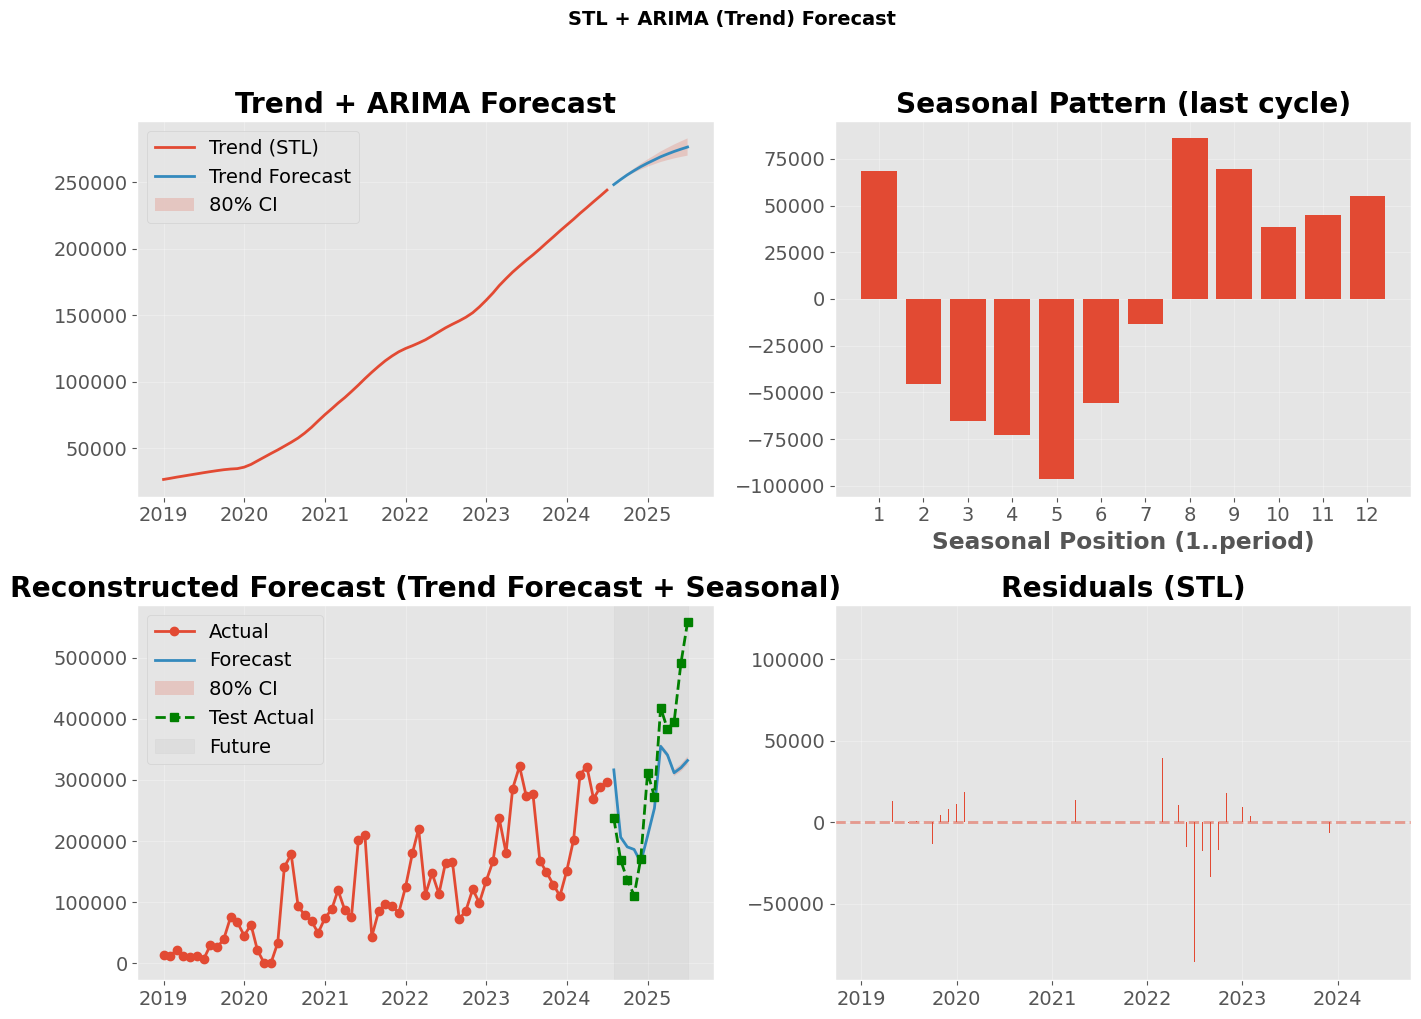

In [75]:
from statsmodels.tsa.arima.model import ARIMA
d = train
y = pd.to_numeric(d['Revenue'], errors='coerce')


# STL decomposition
period = 12
stl = STL(y, period=period, robust=True)
res = stl.fit()
trend, seasonal, resid = res.trend, res.seasonal, res.resid # Get the trend, seasonality, and residual separately

# Use ARIMA 对“趋势”建模并预测 ——
trend_clean = trend.dropna()
steps = 12
arima_order=(1,1,1)

model = ARIMA(trend_clean, order=arima_order)
fit = model.fit()

trend_fc = fit.get_forecast(steps=steps)
trend_fc_mean = trend_fc.predicted_mean
trend_fc_ci = trend_fc.conf_int(alpha=0.2)  # 80%区间

future_idx = pd.date_range(start=trend_clean.index[-1] + pd.offsets.MonthBegin(1),
                               periods=steps, freq='MS')


# —— 构造未来季节性：复制最近一个“完整季节周期”的 pattern ——
if len(seasonal.dropna()) >= period:
    recent_seasonal = seasonal.dropna()[-period:].values
else:
        # 数据不足一个周期时，退化为用历史季节的均值
    recent_seasonal = np.full(steps, seasonal.dropna().mean() if len(seasonal.dropna()) else 0.0)

# 将季节性重复/截断到 steps 长度
future_seasonal = np.resize(recent_seasonal, steps)

# —— 重构未来预测 = 预测的趋势 + 未来季节性 ——
recon_fc = trend_fc_mean.values + future_seasonal
recon_fc_series = pd.Series(recon_fc, index=future_idx, name='Forecast')

# —— “重构预测”的置信区间（仅来自趋势不确定性；季节性视为确定） ——
# 把 CI 中点与 trend_fc_mean 的差当做误差带到重构预测上
ci_lower = trend_fc_ci.iloc[:, 0].values + future_seasonal
ci_upper = trend_fc_ci.iloc[:, 1].values + future_seasonal

# —— 可视化：趋势+趋势预测；季节性模式；最终重构预测 vs 实际 ——
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# (A) 趋势 + 趋势预测
axes[0, 0].plot(trend.index, trend.values, label='Trend (STL)', linewidth=2)
axes[0, 0].plot(trend_fc_mean.index, trend_fc_mean.values, label='Trend Forecast', linewidth=2)
axes[0, 0].fill_between(trend_fc_mean.index, trend_fc_ci.iloc[:, 0], trend_fc_ci.iloc[:, 1],
                            alpha=0.2, label='80% CI')
axes[0, 0].set_title('Trend + ARIMA Forecast', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

    # (B) 季节性（展示一个完整周期）
if len(seasonal.dropna()) >= period:
        # 把季节性按月份展开对齐显示
    seasonal_last_cycle = seasonal.dropna()[-period:]
    axes[0, 1].bar(range(1, period+1), seasonal_last_cycle.values)
    axes[0, 1].set_xticks(range(1, period+1))
    axes[0, 1].set_xlabel('Seasonal Position (1..period)')
    axes[0, 1].set_title('Seasonal Pattern (last cycle)', fontweight='bold')
else:
    axes[0, 1].plot(seasonal.index, seasonal.values)
    axes[0, 1].set_title('Seasonal Component', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# (C) 最终重构预测 vs 实际（仅展示尾部历史以避免过拥挤）
tail_hist_months=67
hist_tail = y.iloc[-tail_hist_months:] if tail_hist_months else y
axes[1, 0].plot(hist_tail.index, hist_tail.values, label='Actual', marker='o')
axes[1, 0].plot(recon_fc_series.index, recon_fc_series.values, label='Forecast', linewidth=2)
axes[1, 0].fill_between(recon_fc_series.index, ci_lower, ci_upper, alpha=0.2, label='80% CI')
axes[1, 0].plot(test.index, test['Revenue'], 
                label='Test Actual', 
                marker='s', linestyle='--', color='green')
axes[1, 0].axvspan(recon_fc_series.index.min(), recon_fc_series.index.max(), color='gray', alpha=0.08, label='Future')
axes[1, 0].set_title('Reconstructed Forecast (Trend Forecast + Seasonal)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# (D) 残差（看异常月）
axes[1, 1].bar(resid.index, resid.values)
axes[1, 1].axhline(0, linestyle='--', alpha=0.5)
axes[1, 1].set_title('Residuals (STL)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

fig.suptitle(f'STL + ARIMA (Trend) Forecast', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

    


In [77]:
results = accuracy(recon_fc_series, test['Revenue'], train['Revenue'], modelname="Prophet")
results

,MAE,RMSE,MAPE,MASE
Prophet,80054.798242,100283.319189,0.274175,2.214057


# Machine Learning Method